In [25]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os
import math

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [26]:
# 8. Practice training a deep neural network on the CIFAR10 image dataset

In [27]:
# Let's load the dataset

In [28]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [29]:
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [30]:
X_train.shape, y_train.shape

((45000, 32, 32, 3), (45000, 1))

In [31]:
X_valid.shape, y_valid.shape

((5000, 32, 32, 3), (5000, 1))

In [32]:
X_valid.shape, y_valid.shape

((5000, 32, 32, 3), (5000, 1))

In [33]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [35]:
# a. Build a DNN with 20 hidden layers of 100 neurons each. Use He initialization and the ELU activation function

In [36]:
model = keras.models.Sequential()

# Input
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Hidden
for _ in range(20):
  model.add(keras.layers.Dense(100,
                               activation='elu',
                               kernel_initializer='he_normal'))
# Output
model.add(keras.layers.Dense(10,
                             activation='softmax'))

In [37]:
# b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=5e-5),
              metrics=['accuracy'])

In [38]:
# Let's also add some callbacks we need to train the model

In [39]:
# Early stopping
early_stopping_cb   = keras.callbacks.EarlyStopping(patience=20)

# Checkpoint
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_model.h5", save_best_only=True)

# TensorBoard
run_index      = 1 # increment every time you train the model
run_logdir     = os.path.join(os.curdir, "cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [40]:
# model.fit(X_train, y_train, epochs=100,
#           validation_data=(X_valid, y_valid),
#           callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb])

In [41]:
# model = keras.models.load_model("cifar10_model.h5")
# model.evaluate(X_valid, y_valid)

In [42]:
# c. Now try adding Batch Normalization (BN) and compare the learning curves.
# Is it converging faster than before? Does it produce a better model?
# How does it affect training speed?

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [44]:
model = keras.models.Sequential()

# Input
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())

# Hidden
for _ in range(20):
  model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation('elu'))

# Output
model.add(keras.layers.Dense(10, activation='softmax'))

In [45]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=5e-4), # vs. 5e-5 before
              metrics=['accuracy'])

In [46]:
# Early stopping
early_stopping_cb   = keras.callbacks.EarlyStopping(patience=20)

# Checkpoint
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_bn_model.h5", save_best_only=True)

# TensorBoard
run_index      = 1 # increment every time you train the model
run_logdir     = os.path.join(os.curdir, "cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [47]:
# model.fit(X_train, y_train, epochs=100,
#           validation_data=(X_valid, y_valid),
#           callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb])

In [48]:
# model = keras.models.load_model("cifar10_bn_model.h5")
# model.evaluate(X_valid, y_valid)

In [49]:
# -> Is the model converging faster than before?
# Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs
# and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.

# -> Does BN produce a better model?
# Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model,
# but at least it's much better than before (a CNN would do much better, but that's a different topic).

# -> How does BN affect training speed?
# Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers.
# But overall the training time (wall time) was shortened significantly!

In [50]:
# d. Try replacing Batch Normalization with SELU, and make the necessary adjust ements to ensure the network self-normalizes
# (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.)

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model = keras.models.Sequential()

# Input
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Hidden
for _ in range(20):
  model.add(keras.layers.Dense(100,
                               kernel_initializer='lecun_normal',
                               activation='selu'))

# Output
model.add(keras.layers.Dense(10, activation='softmax'))

In [53]:
# Let's standardize the input features
# Another option is to add a BN layer after the Flatter layer (as input) => this will normalize the data automatically
X_means = X_train.mean(axis=0)
X_stds  = X_train.std(axis=0)

X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled  = (X_test - X_means)  / X_stds

In [54]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=7e-4), # vs. 5e-5, 5e-4 before
              metrics=['accuracy'])

In [55]:
# Early stopping
early_stopping_cb   = keras.callbacks.EarlyStopping(patience=20)

# Checkpoint
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_self_norm_model.h5", save_best_only=True)

# TensorBoard
run_index      = 1 # increment every time you train the model
run_logdir     = os.path.join(os.curdir, "cifar10_logs", "run_self_norm_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [56]:
# model.fit(X_train, y_train, epochs=100,
#           validation_data=(X_valid, y_valid),
#           callbacks=[early_stopping_cb, model_checkpoint_cb, tensorboard_cb])

In [57]:
# model = keras.models.load_model("cifar10_self_norm_model.h5")
# model.evaluate(X_valid, y_valid)

In [58]:
# e. Try regularizing the model with alpha dropout. Then, without retraining your
# model, see if you can achieve better accuracy using MC Dropout.

In [59]:
keras.backend.clear_session()
tf.random.set_seed(42)

In [60]:
model = keras.models.Sequential()

# Input
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Hiddens (Dense + AlphaDropout)
for _ in range(20):
  model.add(keras.layers.Dense(100,
                               kernel_initializer='lecun_normal',
                               activation='selu'))
  model.add(keras.layers.AlphaDropout(rate=0.1))

# Output
model.add(keras.layers.Dense(10, activation='softmax'))

In [61]:
# I am using AlphaDropout instead of vanilla Dropout because it preserves the self-normalization feature

In [62]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=5e-4),
              metrics=['accuracy'])

In [63]:
# Early stopping
early_stopping_cb   = keras.callbacks.EarlyStopping(patience=20)

# Checkpoint
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("cifar10_alpha_dropout_model.h5", save_best_only=True)

# TensorBoard
run_index      = 1 # increment every time you train the model
run_logdir     = os.path.join(os.curdir, "cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [64]:
# Let's fit the model again on the scaled data

# model.fit(X_train_scaled, y_train, epochs=100,
#           validation_data=(X_valid_scaled, y_valid),
#           callbacks=callbacks)

In [65]:
# model = keras.models.load_model("cifar10_alpha_dropout_model.h5")
# model.evaluate(X_valid_scaled, y_valid)

In [66]:
# Let's use MCDroput now

# I created a new class for more robustness (e.g.: if we have some layers which works different at training & inference time BN let's say,
# then we can't just 'hardcode' the arg `training=True` on the entire model, because it will break the BN layer)
# For more details, see: https://keras.io/api/layers/normalization_layers/batch_normalization/

# In conclusion, we will only force the AlphaDropout layer to be active (even at) inference for performing MonteCarlo experiment

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [67]:
# Now let's create a new model, identical to the one we just trained (with the same weights), but with MCAlphaDropout dropout layers instead of AlphaDropout layers
mc_model = keras.models.Sequential([MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers])

In [68]:
# Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities.
# The second will use these mean probabilities to predict the most likely class for each instance

In [69]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [70]:
# Now let's make predictions for all the instances in the validation set, and compute the accuracy

In [71]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [72]:
# y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
# accuracy = np.mean(y_pred == y_valid[:, 0])
# accuracy

In [73]:
# f. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy

In [74]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [75]:
model = keras.models.Sequential()

# Input
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Hiddens (Dense + AlphaDropout)
for _ in range(20):
  model.add(keras.layers.Dense(100,
                               kernel_initializer='lecun_normal',
                               activation='selu'))
  model.add(keras.layers.AlphaDropout(rate=0.1))

# Output
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

In [76]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 10s 23ms/step - loss: nan - accuracy: 0.1042


(9.999999747378752e-06,
 9.615227699279785,
 2.865111827850342,
 4.178337029048375)

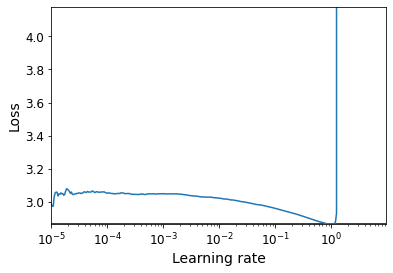

In [77]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [78]:
# 1cycle scheduling

# Contrary to the other approaches, 1cycle (introduced in a 2018 paper21 by Leslie Smith)
# starts by increasing the initial learning rate η0 , growing linearly up to η1
# halfway through training. Then it decreases the learning rate linearly down to η0
# again during the second half of training, finishing the last few epochs by dropping the rate down
# by several orders of magnitude (still linearly). The maximum learning rate η1
# is chosen using the same approach we used to find the optimal learning rate (see plot above),
# and the initial learning rate η0 is chosen to be roughly 10 times lower.

# When using a momentum, we start with a high momentum first
# (e.g., 0.95), then drop it down to a lower momentum during the first half of training
# (e.g., down to 0.85, linearly), and then bring it back up to the maximum value
# (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value.

In [79]:
# We can see that a good maximum learning rate η1 is 0.05

In [80]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [81]:
model = keras.models.Sequential()

# Input
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Hiddens (Dense + AlphaDropout)
for _ in range(20):
  model.add(keras.layers.Dense(100,
                               kernel_initializer='lecun_normal',
                               activation='selu'))
  model.add(keras.layers.AlphaDropout(rate=0.1))

# Output
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-2),
              metrics=['accuracy'])

In [82]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
        
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [83]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)

In [84]:
# history  = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
#                      validation_data=(X_valid_scaled, y_valid),
#                      callbacks=[onecycle])